In [1]:
# pip install gdown GoogleDriveDownloader

In [2]:
# import gdown

# url = 'https://drive.google.com/file/d/1sU-nLpYuCI65h7MjFJKG0yphNAlUFSKG'
# output = '/home/d.vinichenko/MedViT/MedViT_large_im1k.pth'
# gdown.download(url, output, quiet=False)

In [1]:
!git clone https://github.com/Omid-Nejati/MedViT.git


fatal: destination path 'MedViT' already exists and is not an empty directory.


In [2]:
%cd /home/d.vinichenko/MedViT

/home/d.vinichenko/MedViT


In [3]:
%ls

Colab_MedViT.ipynb  LICENSE                README.md         swinv2-base/
CustomDataset/      MedViT/                requirements.txt  utils.py
CustomDataset.md    MedViT_large_im1k.pth  short_dataset/
images/             MedViT.py              short_test/
Instructions.ipynb  __pycache__/           short_test.zip


In [4]:
!pip install -r requirements.txt

In [5]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

from PIL import Image
# from torchinfo import summary
import torch
import os
import warnings
warnings.filterwarnings("ignore")
from typing import Tuple

from PIL import Image
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from datasets import load_dataset
import pandas as pd

import random

# import wandb
# wandb.login("1fa58b4e42c64c2531b3abeb43c04f5991be307e")

torch.cuda.empty_cache()


In [6]:
# !wandb login 1fa58b4e42c64c2531b3abeb43c04f5991be307e

In [7]:
print('Number CUDA Devices:', torch.cuda.device_count())
print ('Current cuda device: ', torch.cuda.current_device(), ' **May not correspond to nvidia-smi ID above, check visibility parameter')

Number CUDA Devices: 1
Current cuda device:  0  **May not correspond to nvidia-smi ID above, check visibility parameter


In [8]:
head_dim = 32

In [9]:
from transformers import PretrainedConfig
from typing import List


class MedViTConfig(PretrainedConfig):
    model_type = "medvit"

    def __init__(
        self,
        stem_chs: List[int] = [64, 32, 64],
        depths: List[int] = [3, 4, 30, 3],
        path_dropout: float = 0.2,
        attn_drop: int = 0,
        drop: int = 0,
        num_classes: int = 5,
        strides: List[int] = [1, 2, 2, 2],
        sr_ratios: List[int] = [8, 4, 2, 1],
        head_dim: int = head_dim,
        mix_block_ratio: float = 0.75,
        use_checkpoint: bool = False,
        pretrained: bool = False,
        pretrained_cfg: str = None,
        **kwargs
    ):
        self.stem_chs = stem_chs
        self.depths = depths
        self.path_dropout = path_dropout
        self.attn_drop = attn_drop
        self.drop = drop
        self.num_classes = num_classes
        self.strides = strides
        self.sr_ratios = sr_ratios
        self.head_dim = head_dim
        self.mix_block_ratio = mix_block_ratio
        self.use_checkpoint = use_checkpoint
        self.pretrained = pretrained,
        self.pretrained_cfg = pretrained_cfg
        super().__init__(**kwargs)

medvit_config = MedViTConfig(num_classes=5, pretrained=False)
medvit_pretrained_config = MedViTConfig(pretrained=True, pretrained_cfg='MedViT_large_im1k.pth')

In [10]:
from MedViT import MedViT, MedViT_large
model = MedViT_large()
# model.load_state_dict()

initialize_weights...


In [11]:
ls

Colab_MedViT.ipynb  LICENSE                README.md         swinv2-base/
CustomDataset/      MedViT/                requirements.txt  utils.py
CustomDataset.md    MedViT_large_im1k.pth  short_dataset/
images/             MedViT.py              short_test/
Instructions.ipynb  __pycache__/           short_test.zip


In [12]:
state_dict = torch.load('MedViT_large_im1k.pth') # weights_only=False
# model.load_state_dict()


In [13]:
model.load_state_dict(torch.load('MedViT_large_im1k.pth')['model'])

<All keys matched successfully>

In [14]:
# model.state_dict()

In [15]:
from transformers import PreTrainedModel
from MedViT import MedViT, MedViT_large

class MedViTClassification(PreTrainedModel):
    config_class = MedViTConfig

    def __init__(self, config, pretrained=False):
        super().__init__(config)

        if pretrained is False:
          print('Initialized with random weights:')
          self.model = MedViT(
          stem_chs = config.stem_chs,
          depths = config.depths,
          path_dropout = config.path_dropout,
          attn_drop = config.attn_drop,
          drop = config.drop,
          num_classes = config.num_classes,
          strides = config.strides,
          sr_ratios = config.sr_ratios,
          head_dim = config.head_dim,
          mix_block_ratio = config.mix_block_ratio,
          use_checkpoint = config.use_checkpoint)
        else:
          print('Initialized with pretrained weights:')
          self.model = MedViT_large(use_checkpoint = config.use_checkpoint)
          # self.state_dict = torch.load(config.pretrained_cfg, weights_only=True)
          self.model.load_state_dict(torch.load(config.pretrained_cfg, weights_only=True)['model'])

    def forward(self, pixel_values, labels=None):
            logits = self.model(pixel_values)
            # loss = torch.nn.CrossEntropyLoss(logits, labels)
            # loss = torch.nn.functional.cross_entropy(logits, labels)
            if labels is not None:
                loss = torch.nn.functional.cross_entropy(logits, labels)
                return {"loss": loss, "logits": logits}
            return {"logits": logits}


In [16]:
model = MedViTClassification(medvit_pretrained_config, pretrained=True)

Initialized with pretrained weights:
initialize_weights...


In [17]:
# %cd ../

In [18]:
ls

Colab_MedViT.ipynb  LICENSE                README.md         swinv2-base/
CustomDataset/      MedViT/                requirements.txt  utils.py
CustomDataset.md    MedViT_large_im1k.pth  short_dataset/
images/             MedViT.py              short_test/
Instructions.ipynb  __pycache__/           short_test.zip


In [19]:
import zipfile
with zipfile.ZipFile('short_test.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [20]:
# Second option: also from folder with train and test
# !!! it is used for own preprocessor (the same for the 3-rd option)

dataset_folder_name = './short_test'


def load_dataset_path2images(dataset_folder_name):
    train_test_folders = os.listdir(dataset_folder_name)
    datasets = {}
    # for trts_split in train_test_folders:
        # class_folders = os.listdir(dataset_folder_name+'/'+trts_split)
    labels = []
    pathes = []
        # for class_folder in class_folders:
    for trts_split in train_test_folders:
            image_names = os.listdir(dataset_folder_name+'/'+trts_split+'/')
            image_names = [dataset_folder_name+'/'+trts_split+'/'+'/'+x for x in image_names]
            class_labels = [int(trts_split)]*len(image_names)
            labels.extend(class_labels)
            pathes.extend(image_names)
    local_dataset = {'image_path': pathes, 'label':labels}
    datasets[trts_split] = pd.DataFrame.from_dict(local_dataset)

    return datasets

dataset = load_dataset_path2images(dataset_folder_name)

train_dataset = dataset['3']
# test_dataset = dataset['test']

In [21]:
train_dataset

,image_path,label
0,./short_test/4//9608_left.jpeg,4
1,./short_test/4//9156_left.jpeg,4
2,./short_test/4//8462_right.jpeg,4
3,./short_test/4//9298_right.jpeg,4
4,./short_test/4//9298_left.jpeg,4
...,...,...
245,./short_test/3//5789_left.jpeg,3
246,./short_test/3//6537_left.jpeg,3
247,./short_test/3//6687_left.jpeg,3
248,./short_test/3//5814_right.jpeg,3


In [22]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
from datasets import Dataset
from transformers import ViTImageProcessor
from transformers import AutoImageProcessor

# model_name_or_path = 'google/vit-base-patch16-224-in21k'
# model_name_or_path = "microsoft/swinv2-tiny-patch4-window8-256"
model_name_or_path = "microsoft/swin-base-patch4-window12-384"

# processor = ViTImageProcessor.from_pretrained(model_name_or_path)
image_processor = AutoImageProcessor.from_pretrained(model_name_or_path)

class Sharpness(object):
    def __init__(self, level=None, prob = 0.5):

        self.level_range = [0.4, 0.8]
        self.prob = prob

    def __get_parameter(self):
        return np.random.uniform(self.level_range[0], self.level_range[1])

    def __call__(self, image, target=None):
        if random.random() < self.prob:
            #print('Sharpness')
            sharpness_factor = self.__get_parameter()
            image = F.adjust_sharpness(image, sharpness_factor)
        return image

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

print(size)

_transforms_train = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomVerticalFlip(p = 0.5),
    T.Resize((224,224)),
    Sharpness()
])

def load_image(path_image, label, mode):
    # load image
    image = Image.open(path_image)

    if mode == 'train':
        image = _transforms_train(image)

        return image
    else:
        return image


def func_transform(examples):

    # loaded_images = [load_image(path, lb, 'train').convert("RGB") for path, lb in zip(examples['image_path'], examples['label'])]
    # _transforms(img.convert("RGB"))
    inputs = image_processor([load_image(path, lb, 'train')
                                for path, lb in zip(examples['image_path'], examples['label'])], return_tensors='pt')
    inputs['label'] = examples['label']
    return inputs

    ###############################

    # examples["pixel_values"] = [load_image(path, lb, 'train')
    #                             for path, lb in zip(examples['image_path'], examples['label'])]
    # del examples["image_path"]
    # return examples



def func_transform_test(examples):

    # loaded_images = [load_image(path, lb, 'test').convert("RGB") for path, lb in zip(examples['image_path'], examples['label'])]
    inputs = image_processor([load_image(path, lb, 'test')
                                for path, lb in zip(examples['image_path'], examples['label'])], return_tensors='pt')
    inputs['label'] = examples['label']
    return inputs

    ########################################
    # examples["pixel_values"] = [load_image(path, lb, 'test')
    #                             for path, lb in zip(examples['image_path'], examples['label'])]
    # del examples["image_path"]
    # return examples



train_ds = Dataset.from_pandas(train_dataset, preserve_index=False)
# test_ds = Dataset.from_pandas(test_dataset, preserve_index=False)

prepared_ds_train = train_ds.with_transform(func_transform)
# prepared_ds_test = test_ds.with_transform(func_transform_test)

prepared_ds_train = prepared_ds_train.shuffle(seed=42)
# prepared_ds_test = prepared_ds_test.shuffle(seed=42)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


(384, 384)


In [23]:
prepared_ds_train

Dataset({
    features: ['image_path', 'label'],
    num_rows: 250
})

In [24]:
print("rows in train_dataset: ", len(prepared_ds_train))
# print("rows in test_dataset: ", len(prepared_ds_test))

# labels = prepared_ds_train.features["label"].names()
labels = [0, 1, 2, 3, 4]
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print("ID2label: ", id2label)

rows in train_dataset:  250
ID2label:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


In [25]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        # 'tensor': torch.stack([x['tensor'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [26]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.metrics import f1_score #, kappa
# from sklearn import metrics

import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions_proba, labels = eval_pred

    # print(predictions)
    predictions = np.argmax(predictions_proba, axis=1)
    # print(predictions)
    # print(labels)
    result_accuracy = accuracy.compute(predictions=predictions, references=labels)

    result = {
             'accuracy': np.mean([result_accuracy['accuracy']]),
             'kappa': np.mean([cohen_kappa_score(labels, predictions, weights = "quadratic")]),
             # 'quadratic_kappa': np.mean([kappa(labels, predictions, weights = "quadratic")]),
             'f1': np.mean([f1_score(labels, predictions, average='weighted')]),
             # 'roc_auc': np.mean([roc_auc_score(labels, predictions_proba, multi_class='ovr')])
             }

    cm = confusion_matrix(labels, predictions)
    print(cm)

    # print(cohen_kappa_score(labels, predictions))
    # print(result)

    return result


In [27]:
# from transformers import Swinv2ForImageClassification
# from transformers import SwinForImageClassification

# model = SwinForImageClassification.from_pretrained(
#     model_name_or_path,
#     num_labels=len(labels),
#     id2label=id2label,
#     label2id=label2id,
#     ignore_mismatched_sizes=True,
# )

In [28]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./swinv2-base",
    evaluation_strategy="steps",
    logging_steps=20,

    save_steps=20,
    eval_steps=20,
    save_total_limit=2,

    # report_to="wandb",  # enable logging to W&B
    # run_name="swin384_shrp_rt20",  # name of the W&B run (optional)

    remove_unused_columns=False,
    dataloader_num_workers = 2,

    learning_rate=2e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=2,
    num_train_epochs=10,
    warmup_ratio=0.1,

    metric_for_best_model="kappa",
    greater_is_better = True,
    load_best_model_at_end=True,

    push_to_hub=False
)

In [29]:
# sample_ids = np.random.choice(len(prepared_ds_test), size=1000, replace=False)
# inv_sample_ids = np.setdiff1d(np.arange(len(prepared_ds_test)), sample_ids)
# val_ds = prepared_ds_test.select(sample_ids)
# test_ds = prepared_ds_test.select(inv_sample_ids)

In [30]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds_train,
    eval_dataset=prepared_ds_train,
    # eval_dataset=val_ds,
    # tokenizer=image_processor,
)

In [69]:
# model.model.features[-1].e_mhsa # 6 + 5 * k

In [32]:
# train_results = trainer.train()
# trainer.save_model()
# trainer.log_metrics("train", train_results.metrics)
# trainer.save_metrics("train", train_results.metrics)
# trainer.save_state()

In [33]:
from transformers import AutoFeatureExtractor
from transformers import ViTImageProcessor

feature_extractor = ViTImageProcessor.from_pretrained("microsoft/swin-base-patch4-window12-384")

transform  = T.Resize((384, 384))

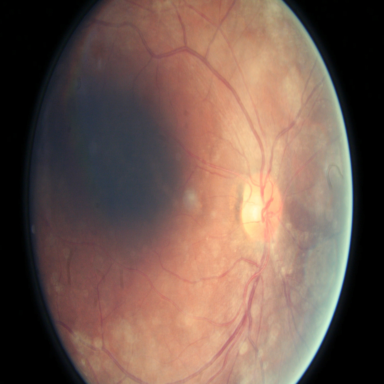

In [34]:
file_name = train_dataset.image_path[0]
image = Image.open(file_name)
image = transform(image)
image

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import gc
torch.cuda.empty_cache()
gc.collect()

In [36]:
inputs = feature_extractor(images=image, return_tensors="pt").to(device)


In [39]:
# pip install torchdistill

In [40]:
from torchdistill.core.forward_hook import ForwardHookManager


In [41]:
forward_hook_manager = ForwardHookManager(device)
forward_hook_manager.add_hook(model, 'model.features.-1.e_mhsa.q', requires_input=False, requires_output=True)
forward_hook_manager.add_hook(model, 'model.features.-1.e_mhsa.k', requires_input=False, requires_output=True)


In [42]:
model.eval()
logits = model(**inputs)

In [45]:
num_heads = int(768 / head_dim)

q = io_dict['model.features.-1.e_mhsa.q']['output'].squeeze()
k = io_dict['model.features.-1.e_mhsa.k']['output'].squeeze()


(torch.Size([144, 768]), torch.Size([144, 768]))

In [46]:
q = q.reshape(q.shape[0], num_heads, q.shape[1] // num_heads)
q = q.permute(1, 0, 2)

k = k.reshape(k.shape[0], num_heads, k.shape[1] // num_heads)
k = k.permute(1, 0, 2)

kT = k.permute(0, 2, 1)

attention_matrix = q @ kT


torch.Size([24, 144, 32])

In [50]:

# Average the attention weights across all heads.
attention_matrix_mean = torch.mean(attention_matrix, dim=0)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(attention_matrix_mean.size(1)).to(device)
aug_att_mat = attention_matrix_mean + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size()).to(device)
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    

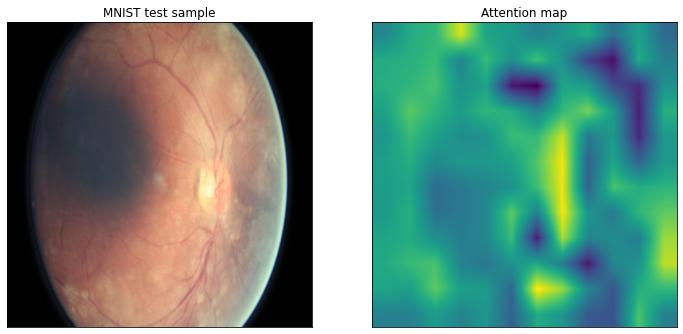

In [68]:


attn_heatmap = joint_attentions[0, :].reshape((12, 12))
attn_heatmap_resized = torch.nn.functional.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [384, 384], mode='bilinear').view(384, 384, 1)




# Visualize attention map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image, cmap='gray')
ax1.set_title('MNIST test sample')
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False)

ax2.imshow(attn_heatmap_resized.squeeze().detach().cpu().numpy())
ax2.set_title('Attention map')
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
